In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate
#from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

## pipeline

### Data Loader

Python provides a lot of packages to load files in different formats. We provide a simple data loader to help you load .csv files.

In [2]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["id"], df["text"], df["label"]

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["label"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

### Feature Extractor

The **feature extractor** is one of the most important parts in a pipeline.
In this tutorial, we introduce four different functions to extract features.

In [3]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [4]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

### Make Data Ready

Now we have the data loader, feature extractor, and the classifier. We can connect them to finish this pipeline of classification. We follow the setting in Tutorial 2 and only select the features whose frequencies are no less than 5.

In [22]:
train_file = "data/train.csv"
test_file = "data/test.csv"
ans_file = "data/ans.csv"
pred_file = "data/pred.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
test_ids, test_texts, _ = load_data(test_file)
test_labels = load_labels(ans_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]

# build the feature list
train_feats = list()
for i in range(len(train_ids)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
test_feats = list()
for i in range(len(test_ids)):
    test_feats.append(
        test_stemmed[i] + test_2_gram[i] + test_3_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
test_label_matrix = keras.utils.to_categorical(test_labels-1, num_classes=num_classes)

Size of features: 7630
0       5
1       4
2       5
3       5
4       5
       ..
1995    4
1996    5
1997    5
1998    4
1999    5
Name: label, Length: 2000, dtype: int64


### Feature Analysis

Firstly, we can check the stemmed features.

stemmed feature size: 9933


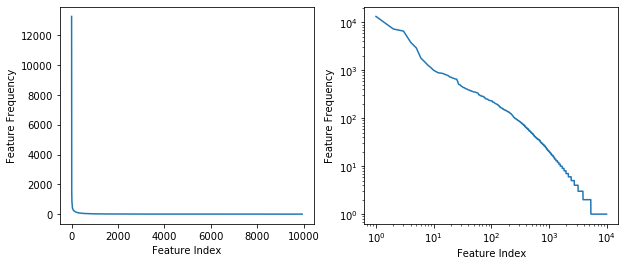

In [6]:
# first, build a Counter for stemmed features, e.g., {"text": 2, "mine": 1}
# counter() is a dictionary
stemmed_feat_cnt = Counter() # from collections import Counter
for feats in train_stemmed:
    stemmed_feat_cnt.update(feats)
print("stemmed feature size:", len(stemmed_feat_cnt))

# then, get the sorted features by the frequency
stemmed_feat_keys = [f for f, cnt in stemmed_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
# set the figure size
plt.figure(figsize=(10,4))
# generate two subfigures and set current as the first one
plt.subplot(1,2,1)
# draw linear lines
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys])
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# set current as the second one
plt.subplot(1,2,2)
# draw log lines
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
           [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10)
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

Then, we compare the stemmed, 2-gram and 3-gram features together.

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


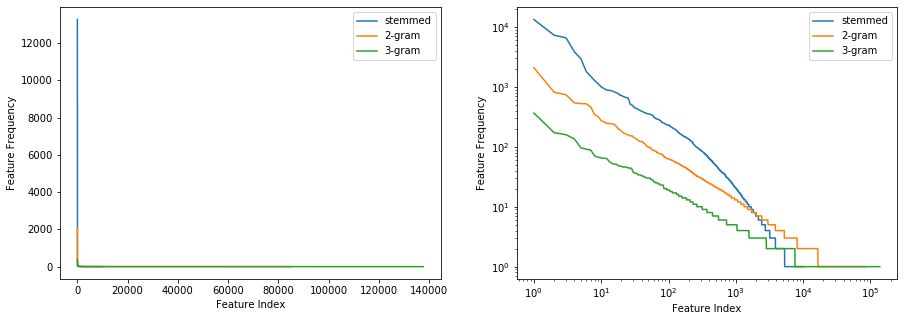

stemmed feature size: 9933
2-gram feature size: 85366
3-gram feature size: 137624


In [10]:
# build Counters for 2-gram features and 3-gram features
bi_gram_feat_cnt = Counter()
for feats in train_2_gram:
    bi_gram_feat_cnt.update(feats)
    
tri_gram_feat_cnt = Counter()
for feats in train_3_gram:
    tri_gram_feat_cnt.update(feats)

# then, get the sorted features by the frequency
bi_gram_feat_keys = [f for f, cnt in bi_gram_feat_cnt.most_common()]
tri_gram_feat_keys = [f for f,cnt in tri_gram_feat_cnt.most_common()]

# draw linear lines and log lines for sorted features
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# put the four linear lines together
plt.plot(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
         label="stemmed")
plt.plot(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
         label="2-gram")
plt.plot(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
         label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.subplot(1,2,2)
# put the four log lines together
plt.loglog(range(1, len(stemmed_feat_cnt)+1),
         [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10, label="stemmed")
plt.loglog(range(1, len(bi_gram_feat_cnt)+1),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
           basex=10, basey=10, label="2-gram")
plt.loglog(range(1, len(tri_gram_feat_cnt)+1),
         [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10, label="3-gram")
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# show the legend
plt.legend()
plt.show()

print("stemmed feature size:", len(stemmed_feat_cnt))
print("2-gram feature size:", len(bi_gram_feat_cnt))
print("3-gram feature size:", len(tri_gram_feat_cnt))



As we can see, linear lines are not suitable to analyze. From the log view, we can find more than 80% features are low-frequent.
And only about 3000 features occur no less than 10 times.

In [11]:
print("stemmed features > 10:",
      len([f for f, cnt in stemmed_feat_cnt.items() if cnt > 10]))
print("2-gram features > 10:",
      len([f for f, cnt in bi_gram_feat_cnt.items() if cnt > 10]))
print("3-gram features > 10:",
      len([f for f, cnt in tri_gram_feat_cnt.items() if cnt > 10]))

stemmed features > 10: 1560
2-gram features > 10: 1322
3-gram features > 10: 262


And we can see the top 10 features.

In [12]:
print("stemmed features top 10:",
      stemmed_feat_keys[:10])
print("2-gram features top 10:",
      bi_gram_feat_keys[:10])
print("3-gram features top 10:",
      tri_gram_feat_keys[:10])

stemmed features top 10: ['.', ',', 'I', 'wa', '!', 'thi', "n't", "'s", 'place', 'food']
2-gram features top 10: ['. I', ', I', '! !', '. It', 'thi place', '. We', 'I wa', "I 'm", "I 've", "I n't"]
3-gram features top 10: ['! ! !', '. It wa', ". It 's", '. I wa', ". I 'm", ". I n't", '. I would', '. servic wa', 'thi place .', '. food wa']


### Classifier

In this tutorial, we introduce a 1-layer perceptron to classify reviews. This perceptron includes 1 dense layer with the softmax activation.
Keras is the easiest deep learning framework so that we choose it to build this network.

In [13]:
def build_classifier(input_size, output_size,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     learning_rate=0.1,
                     metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a 1-layer perceptron,
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    # the projection layer
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "Adadelta'":
        optmizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == "Adagrad":
        optmizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == "Adamax":
        optmizer = keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer == "Nadam":
        optmizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    return model

Firstly, we build a single layer perceptron, which can achieve test 57.75% accuracy.

In [14]:
os.makedirs("models", exist_ok=True)
model = build_classifier(input_size=len(feats_dict), output_size=num_classes,)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

#set random seed for reproducing
np.random.seed(0)
tf.random.set_seed(0)
# train the model
slp_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=20, batch_size=100, verbose=0,
                    callbacks=[checkpointer])
#evaluation
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))
train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

4/4 [==============================] - 0s 2ms/step - loss: 1.1003 - accuracy: 0.5725
training loss: 0.7072206735610962 training accuracy 0.7979999780654907
test loss: 1.1003247499465942 test accuracy 0.5724999904632568


## Model Analysis

### Visualize Training History

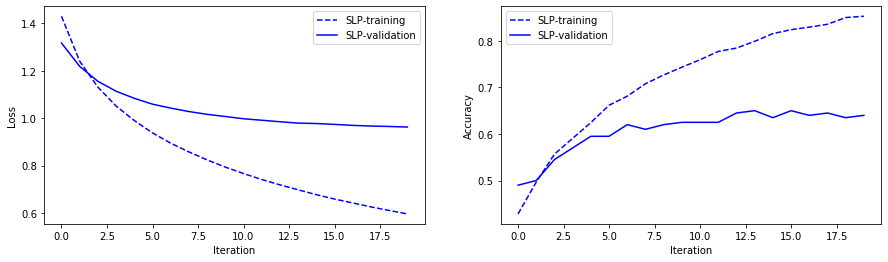

In [15]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(slp_history.history["loss"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_loss"], label="SLP-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(slp_history.history["accuracy"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_accuracy"], label="SLP-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Choose the appropriate Learning Rate

In [16]:
os.makedirs("models", exist_ok=True)

#set random seed
np.random.seed(0)
tf.random.set_seed(0)
#candidate learning rate list
learning_rates = [0.01, 0.1, 0.5]
historys = list()
for lr in learning_rates:
    print('learing rate =' + str(lr)+':' )
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes, learning_rate = lr)
    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", "weights_lr_"+str(lr)+".hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_split=0.1,
                        epochs=20, batch_size=100, verbose=0,
                        callbacks=[checkpointer])
    historys.append(history)
    model = keras.models.load_model(os.path.join("models", "weights_lr_"+str(lr)+".hdf5"))

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                 batch_size=100)
    test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                                batch_size=100)
   

learing rate =0.01:
4/4 [==============================] - 0s 1ms/step - loss: 1.3431 - accuracy: 0.4450
learing rate =0.1:
4/4 [==============================] - 0s 2ms/step - loss: 1.1146 - accuracy: 0.5625
learing rate =0.5:
4/4 [==============================] - 0s 1ms/step - loss: 1.1405 - accuracy: 0.5550


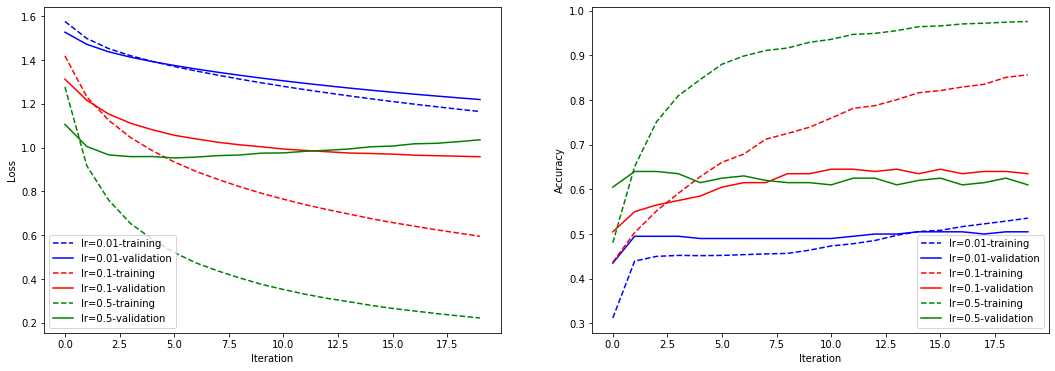

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(historys[0].history["loss"], label="lr=0.01-training", color="blue", linestyle="dashed")
plt.plot(historys[0].history["val_loss"], label="lr=0.01-validation", color="blue")
plt.plot(historys[1].history["loss"], label="lr=0.1-training", color="red", linestyle="dashed")
plt.plot(historys[1].history["val_loss"], label="lr=0.1-validation", color="red")
plt.plot(historys[2].history["loss"], label="lr=0.5-training", color="green", linestyle="dashed")
plt.plot(historys[2].history["val_loss"], label="lr=0.5-validation", color="green")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(historys[0].history["accuracy"], label="lr=0.01-training", color="blue", linestyle="dashed")
plt.plot(historys[0].history["val_accuracy"], label="lr=0.01-validation", color="blue")
plt.plot(historys[1].history["accuracy"], label="lr=0.1-training", color="red", linestyle="dashed")
plt.plot(historys[1].history["val_accuracy"], label="lr=0.1-validation", color="red")
plt.plot(historys[2].history["accuracy"], label="lr=0.5-training", color="green", linestyle="dashed")
plt.plot(historys[2].history["val_accuracy"], label="lr=0.5-validation", color="green")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Grid Search Hyperparameter

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


def build_classifier(input_size, output_size,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     learning_rate=0.1,
                     metric="accuracy"):
    
    model = Sequential()
    
    # the projection layer
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    bias_initializer="zeros"))

    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    return model


np.random.seed(0)
tf.random.set_seed(0)

#Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.
def create_model():
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes,)
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)

# difine grid search parameter 
batch_size = [5, 20,100,300]
epochs = [2, 5, 20, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_feats_matrix, train_label_matrix,)


# grid searching result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.597500 using {'batch_size': 5, 'epochs': 20}
0.531500 (0.025671) with: {'batch_size': 5, 'epochs': 2}
0.581000 (0.020712) with: {'batch_size': 5, 'epochs': 5}
0.597500 (0.020676) with: {'batch_size': 5, 'epochs': 20}
0.585500 (0.016000) with: {'batch_size': 5, 'epochs': 50}
0.462000 (0.029215) with: {'batch_size': 20, 'epochs': 2}
0.513500 (0.027000) with: {'batch_size': 20, 'epochs': 5}
0.572500 (0.031105) with: {'batch_size': 20, 'epochs': 20}
0.587000 (0.015524) with: {'batch_size': 20, 'epochs': 50}
0.454500 (0.026524) with: {'batch_size': 100, 'epochs': 2}
0.456000 (0.028705) with: {'batch_size': 100, 'epochs': 5}
0.493000 (0.025855) with: {'batch_size': 100, 'epochs': 20}
0.542000 (0.030716) with: {'batch_size': 100, 'epochs': 50}
0.406000 (0.028662) with: {'batch_size': 300, 'epochs': 2}
0.455000 (0.028504) with: {'batch_size': 300, 'epochs': 5}
0.458500 (0.030968) with: {'batch_size': 300, 'epochs': 20}
0.490500 (0.024870) with: {'batch_size': 300, 'epochs': 50}


### Choose the appropriate Optimazer with Grid Search

In [19]:
def create_model(optimizer='SGD'):
    model = build_classifier(input_size=len(feats_dict), output_size=num_classes,optimizer=optimizer)
    return model

np.random.seed(0)
tf.random.set_seed(0)

#create the model with the best epoch and batch size found in last step
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=5, verbose=0)

# difine grid search parameter 
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_feats_matrix, train_label_matrix,)

# grid searching result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.587500 using {'optimizer': 'SGD'}
0.587500 (0.019429) with: {'optimizer': 'SGD'}
0.556500 (0.025328) with: {'optimizer': 'RMSprop'}
0.534500 (0.025807) with: {'optimizer': 'Adagrad'}
0.370000 (0.052345) with: {'optimizer': 'Adadelta'}
0.568500 (0.017930) with: {'optimizer': 'Adam'}
0.582500 (0.010724) with: {'optimizer': 'Adamax'}
0.567000 (0.021178) with: {'optimizer': 'Nadam'}
